In [ ]:
from pathlib import Path

#file_path = "./Testing/Loading_and_Predicting_with_a_Trained_Dual_Encoder/dual_encoder_predictions/aida/llm/Google/Trained_Testing_Model/predictions_dev.txt"
file_path = "../Results/shadowlinks-tail/Google/gemini-2.5-flash-lite/2025-11-04_03-59-20/predictions_test.txt"

#Load file line by line
with open(file_path, 'r') as file:
    lines = file.readlines()

# Remove all lines that don't start with '"'
lines = [line for line in lines if line.startswith('"') and '---' in line]

#Split each line in multiple lines at each occurence of '])"'
#The lines list should not include lists but only lines
parsed_lines = []
for line in lines:
    parsed_lines.extend(line.split(')]"'))

In [66]:
import pandas as pd
import json

# Create empty pandas dataframe with columns "Gold", "Predict", "LLMPredict", "Top_k"
# Also add columns for top_{i} and top_{i}_score for i in range(1, max_top_k + 1)

# Get top_k
parameter_file = Path(file_path).parent / "run_parameters.json"
# Load dictionary from json file and extract value for key "top_k"
try:
    with open(parameter_file, 'r') as f:    
        parameters = json.load(f)
    max_top_k = parameters.get("top_k", 5)  # Default to 5 if not found
    prompt_version = parameters.get("Prompt_Version", 1) # Default to 1 if not found
except FileNotFoundError:
    print(f"Warning: {parameter_file} not found. Using default max_top_k = 5.")
    max_top_k = 5  # Default value if the file is not found
    prompt_version = 1

column_names = ["Gold", "Predict", "LLMPredict", "Top_k"]
for i in range(1, max_top_k + 1):
    column_names.append(f"Top_{i}")
    column_names.append(f"Top_{i}_score")
column_names.append("LLM_Start")
column_names.append("LLM_End")
column_names.append("Input_Tokens")
column_names.append("Output_Tokens")
column_names.append("Span_Percentage")
column_names.append("Top_k_Used")

df = pd.DataFrame(columns=column_names)

for idx, line in enumerate(parsed_lines):
    splits = line.split('---')

    gold = splits[0].split('/')[1].strip()
    pred = splits[1].strip()
    llm_pred = splits[2].strip()
    top_k = splits[3].strip()
    llm_iter = splits[4].strip() if len(splits) > 4 else '"N/A", "N/A"'
    input_tokens = int(splits[5].split(',')[0].strip()) if len(splits) > 5 else "0"
    output_tokens = int(splits[5].split(',')[1].strip()) if len(splits) > 5 else "0"
    span_percentage = int(splits[6].strip()) if len(splits) > 6 else -1
    top_k_used = int(splits[7].strip()) if len(splits) > 7 else max_top_k

    # Parse top_k values
    top_k_vals = {}
    top_k_splits = top_k.split('), (')
    top_k = "), (".join([top_k_splits[i] for i in range(top_k_used if top_k_used > 0 else max_top_k)]).strip()
    for i in range(0, max_top_k):
        if i >= top_k_used:
            top_k_vals[i+1] = ("N/A", 0.0)
            continue
        top_i_splits = top_k_splits[i].split(', ')

        # Remove quotes, whitespaces, commas, parenthesises and brackets from strings
        top_k_vals[i+1] = (top_i_splits[0].replace(",", "").replace('"', '').replace("'", "").replace("(", "").replace("[", "").strip(),
                        float(top_i_splits[1].replace(")", "").replace("]", "").strip()))

    
    column_fields = [gold, pred, llm_pred, str(top_k)]
    for i in range(1, max_top_k + 1):
        column_fields.append(top_k_vals[i][0])  # Top_i
        column_fields.append(top_k_vals[i][1])  # Top_i_score
    column_fields.append(llm_iter.split(',')[0].replace('"', '').strip())  # LLM_Start
    column_fields.append(llm_iter.split(',')[1].replace('"', '').strip())  # LLM_End
    column_fields.append(input_tokens)  # Input_Tokens
    column_fields.append(output_tokens)  # Output_Tokens
    column_fields.append(span_percentage)  # Span_Percentage
    column_fields.append(top_k_used)  # Top_k_Used

    df.loc[len(df)] = column_fields

In [67]:
df

,Gold,Predict,LLMPredict,Top_k,Top_1,Top_1_score,Top_2,Top_2_score,Top_3,Top_3_score,...,Top_9,Top_9_score,Top_10,Top_10_score,LLM_Start,LLM_End,Input_Tokens,Output_Tokens,Span_Percentage,Top_k_Used
0,Haskell_Free_Library_and_Opera_House,Baen_Free_Library,Free_Library_of_Philadelphia,"[('Baen_Free_Library', -23.391347885131836), (...",Baen_Free_Library,-23.391348,Scottsville_Free_Library,-23.602613,Free_Library_of_Philadelphia,-23.941591,...,Carnegie_library,-24.879711,Louisville_Free_Public_Library,-24.977480,3,3,516,1,71,10
1,Morris_Fiorina,Morris_Fiorina,Morris_Fiorina,"[('Morris_Fiorina', -21.244613647460938), ('Ca...",Morris_Fiorina,-21.244614,Carly_Fiorina,-24.228449,Lando_Fiorini,-26.841877,...,Semeia,-27.846413,Foroyaa,-27.885900,1,1,484,1,9,10
2,Fijian_language,Fijian_language,Fijian_language,"[('Fijian_language', -17.88295555114746), ('Ro...",Fijian_language,-17.882956,Rotuman_language,-22.516142,Fiji_Hindi,-22.544220,...,Kabalian_language,-23.398621,Jingpho_language,-23.674845,3,3,539,1,96,10
3,"Innis_College,_Toronto",Niger_Innis,National_Institute_of_Policy_and_Strategic_Stu...,"[('Niger_Innis', -25.73035430908203), ('Interc...",Niger_Innis,-25.730354,Intercollegiate_Studies_Institute,-26.164595,Harold_Innis,-26.265070,...,Esalen_Institute,-27.234648,Innisfree_Ltd,-27.251667,3,3,526,1,87,10
4,Glu_Mobile,Glu_Mobile,Glu_Mobile,"[('Glu_Mobile', -24.057390213012695), ('Golu',...",Glu_Mobile,-24.057390,Golu,-24.666420,General_glut,-25.642410,...,SHRDLU,-26.757368,Dwango_company),-26.855692,2,2,471,1,37,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899,Great_Siege_of_Gibraltar,Great_Siege_of_Gibraltar,Great_Siege_of_Gibraltar,"[('Great_Siege_of_Gibraltar', -21.885576248168...",Great_Siege_of_Gibraltar,-21.885576,Great_Fire_of_New_York_1776),-24.879803,Great_Siege_of_Malta,-25.060366,...,Battle_of_Manila_1762),-25.564499,Battle_of_Fraustadt,-25.572878,3,3,617,1,75,10
900,Greenhorn_Limestone,Greenhorn_Limestone,Greenhorn_Limestone,"[('Greenhorn_Limestone', -19.924457550048828),...",Greenhorn_Limestone,-19.924458,Greenhorn_Mountain,-22.035084,Greenhorn_Valley,-23.617579,...,Stock_geology),-26.325708,Matterhorn_Glacier,-26.366249,1,1,494,1,12,10
901,Henry_Greenly,Henry_Greenly,Henry_Greenly,"[('Henry_Greenly', -22.610092163085938), ('Wil...",Henry_Greenly,-22.610092,William_L._Greenly,-25.520531,Denis_Greenhill_Baron_Greenhill_of_Harrow,-26.268957,...,Streetly,-27.163176,John_and_Benjamin_Green,-27.272011,2,2,498,1,37,10
902,"Greetham,_Rutland","Greetham,_Rutland","Greetham,_Rutland","[('Greetham,_Rutland', -14.691644668579102), (...",Greetham_Rutland,-14.691645,Pattingham,-23.377447,Barkham,-24.487362,...,Peckham,-25.425983,Ashwell_Rutland,-25.430531,1,1,517,1,25,10


### Individual Logic

In [68]:
# Calculate distribution of score differences between Top_1_score and Top_2_score

score_diff_list = []
for index, row in df.iterrows():
    score_diff = (row["Top_1_score"]) - float(row["Top_2_score"])
    score_diff_list.append(score_diff)

score_diff_list = sorted(score_diff_list)

for i in range(0, 100, 2):
    print(f"{i}th percentile: {score_diff_list[min(int(len(score_diff_list) * (i / 100)), len(score_diff_list)-1)]}")


0th percentile: 0.0
2th percentile: 0.04011344909667969
4th percentile: 0.07098197937011719
6th percentile: 0.11980247497558594
8th percentile: 0.1755237579345703
10th percentile: 0.20838546752929688
12th percentile: 0.2803230285644531
14th percentile: 0.3199806213378906
16th percentile: 0.397003173828125
18th percentile: 0.4375190734863281
20th percentile: 0.48635292053222656
22th percentile: 0.5359611511230469
24th percentile: 0.6128501892089844
26th percentile: 0.7170066833496094
28th percentile: 0.7809944152832031
30th percentile: 0.8582687377929688
32th percentile: 0.9517478942871094
34th percentile: 1.0318870544433594
36th percentile: 1.0904045104980469
38th percentile: 1.168985366821289
40th percentile: 1.2892265319824219
42th percentile: 1.3791065216064453
44th percentile: 1.4794063568115234
46th percentile: 1.562509536743164
48th percentile: 1.6558074951171875
50th percentile: 1.7551517486572266
52th percentile: 1.8866539001464844
54th percentile: 1.9791793823242188
56th perce

In [69]:
score_diff_list

[0.0,
 1.9073486328125e-06,
 0.00092315673828125,
 0.0023593902587890625,
 0.0054492950439453125,
 0.0067291259765625,
 0.008922576904296875,
 0.0091094970703125,
 0.010797500610351562,
 0.0112152099609375,
 0.014039993286132812,
 0.018123626708984375,
 0.0196990966796875,
 0.023235321044921875,
 0.024263381958007812,
 0.026342391967773438,
 0.03322029113769531,
 0.03428459167480469,
 0.04011344909667969,
 0.04039573669433594,
 0.04417228698730469,
 0.04670524597167969,
 0.05128669738769531,
 0.05129432678222656,
 0.053333282470703125,
 0.05583381652832031,
 0.057308197021484375,
 0.05804634094238281,
 0.05835723876953125,
 0.059101104736328125,
 0.062129974365234375,
 0.06271553039550781,
 0.06474876403808594,
 0.06675910949707031,
 0.07039451599121094,
 0.07042121887207031,
 0.07098197937011719,
 0.07266807556152344,
 0.0756378173828125,
 0.07601547241210938,
 0.0767059326171875,
 0.08228111267089844,
 0.08774948120117188,
 0.09092903137207031,
 0.09280776977539062,
 0.09326744079589

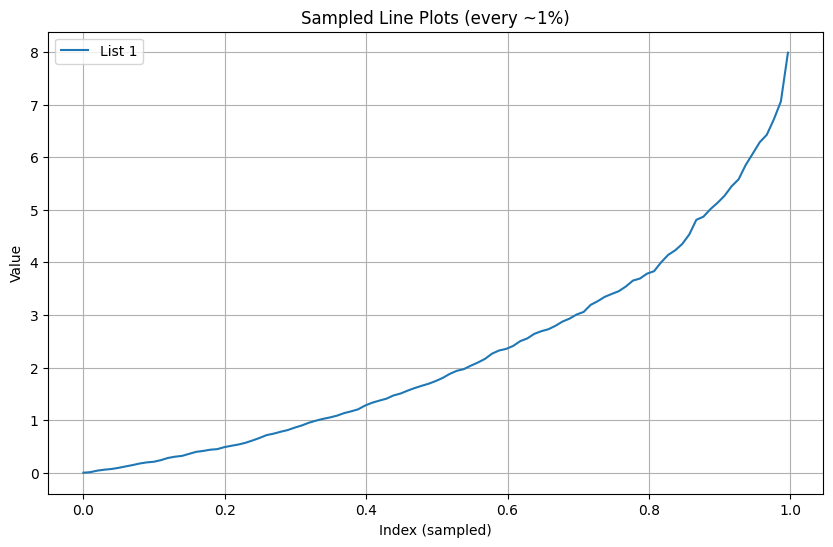

In [70]:
data_lists = [score_diff_list]

import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10, 6))

for i, data in enumerate(data_lists, start=1):
    n = len(data)
    step = max(1, n // 100)  # 100 points ≈ every 1%
    sampled_indices = np.arange(0, n, step)
    sampled_data = np.array(data)[sampled_indices]

    # Convert index to percentage of total length
    percent_x = (sampled_indices / (n - 1))
    
    plt.plot(percent_x, sampled_data, label=f"List {i}")

plt.title("Sampled Line Plots (every ~1%)")
plt.xlabel("Index (sampled)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()